In [1]:
from pyspark.sql import SparkSession
import pyspark
from datetime import datetime
import json
import pandas

# First, stop any existing SparkSession/Context
try:
    spark.stop()
except:
    pass

# Clear any remaining SparkContext
from pyspark import SparkContext
SparkContext.getOrCreate().stop()

spark = SparkSession.builder \
    .appName("DAT535_Project_Test2") \
    .config("spark.executor.memory", "5g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.memory", "2g") \
    .config("spark.driver.cores", "2") \
    .config("spark.executor.instances", "3") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.dynamicAllocation.minExecutors", "1") \
    .config("spark.dynamicAllocation.maxExecutors", "3") \
    .getOrCreate()

spark.catalog.clearCache()
sc = spark.sparkContext

19:00:53.007 [rpc-server-4-4] ERROR org.apache.spark.network.server.TransportRequestHandler - Error while invoking RpcHandler#receive() for one-way message.
org.apache.spark.SparkException: Could not find CoarseGrainedScheduler.
	at org.apache.spark.rpc.netty.Dispatcher.postMessage(Dispatcher.scala:178) ~[spark-core_2.12-3.5.2.jar:3.5.2]
	at org.apache.spark.rpc.netty.Dispatcher.postOneWayMessage(Dispatcher.scala:150) ~[spark-core_2.12-3.5.2.jar:3.5.2]
	at org.apache.spark.rpc.netty.NettyRpcHandler.receive(NettyRpcEnv.scala:690) ~[spark-core_2.12-3.5.2.jar:3.5.2]
	at org.apache.spark.network.server.TransportRequestHandler.processOneWayMessage(TransportRequestHandler.java:274) ~[spark-network-common_2.12-3.5.2.jar:3.5.2]
	at org.apache.spark.network.server.TransportRequestHandler.handle(TransportRequestHandler.java:111) ~[spark-network-common_2.12-3.5.2.jar:3.5.2]
	at org.apache.spark.network.server.TransportChannelHandler.channelRead0(TransportChannelHandler.java:140) ~[spark-network-c

## Bronze layer

In [2]:
reservoir_data_columns = [
    "fyllingsgrad",
    "fylling_TWh",
    "fyllingsgrad_forrige_uke",
    "endring_fyllingsgrad",
    "omrType",
    "iso_aar",
    "iso_uke",
    "kapasitet_TWh",
    "omrnr",
    "dato_Id"
]

power_prices_columns = [
    "timestamp",
    "price",
    "region"
]

def parse_line(line, columns):
    parts = line.split(",")

    return dict(zip(columns, parts))

parsed_water_data = sc.textFile("hdfs://namenode:9000/user/ubuntu/datasets/reservoir_data*.csv") \
    .map(lambda line: parse_line(line, reservoir_data_columns))

parsed_price_data = sc.textFile("hdfs://namenode:9000/user/ubuntu/datasets/power_prices*.csv") \
    .map(lambda line: parse_line(line, power_prices_columns))

print(parsed_water_data.count())
print(parsed_price_data.count())

for record in parsed_water_data.take(1):
    print(record)

for record in parsed_price_data.take(1):
    print(record)

1570470
1271160
{'fyllingsgrad': '0.6074498', 'fylling_TWh': '53.098312', 'fyllingsgrad_forrige_uke': '0.7526065', 'endring_fyllingsgrad': '-0.14515668', 'omrType': 'NO', 'iso_aar': '1995.0', 'iso_uke': '1.0', 'kapasitet_TWh': '87.41185', 'omrnr': '0', 'dato_Id': '1995-01-08 00:00:00'}
{'timestamp': '1995-01-01 00:00:00', 'price': '2.2853', 'region': 'NO1'}


## Silver layer

In [3]:
def clean_water_data(row):
    row["year"] = int(float(row.pop("iso_aar")))
    row["week"] = int(float(row.pop("iso_uke")))
    row["region"] = int(row.pop("omrnr"))
    row["regionType"] = row.pop("omrType")
    row["reservoir_level_change_1w"] = float(row.pop("endring_fyllingsgrad"))
    row["reservoir_level"] = float(row.pop("fyllingsgrad"))
    row["reservoir_level_1w"] = float(row.pop("fyllingsgrad_forrige_uke"))
    row["capacity_TWh"] = float(row.pop("kapasitet_TWh"))
    row["reservoir_TWh"] = float(row.pop("fylling_TWh"))
    row["timestamp"] = datetime.strptime(row.pop("dato_Id"), "%Y-%m-%d %H:%M:%S")

    return row

def clean_price_data(row):
    timestamp = datetime.strptime(row.pop("timestamp"), '%Y-%m-%d %H:%M:%S')
    row["timestamp"] = timestamp
    row["year"] = timestamp.isocalendar().year
    row["week"] = timestamp.isocalendar().week
    row["price"] = float(row.pop("price"))
    row["region"] = int(row.pop("region")[-1])

    return row

        
price_data = parsed_price_data \
    .map(clean_price_data)

water_data = parsed_water_data \
    .map(clean_water_data)

print(price_data.take(5))
print(water_data.take(5))

[{'timestamp': datetime.datetime(1995, 1, 1, 0, 0), 'year': 1994, 'week': 52, 'price': 2.2853, 'region': 1}, {'timestamp': datetime.datetime(1995, 1, 1, 1, 0), 'year': 1994, 'week': 52, 'price': 0.0, 'region': 1}, {'timestamp': datetime.datetime(1995, 1, 1, 2, 0), 'year': 1994, 'week': 52, 'price': 1.97805, 'region': 1}, {'timestamp': datetime.datetime(1995, 1, 1, 3, 0), 'year': 1994, 'week': 52, 'price': 0.0, 'region': 1}, {'timestamp': datetime.datetime(1995, 1, 1, 4, 0), 'year': 1994, 'week': 52, 'price': 0.0, 'region': 1}]
[{'year': 1995, 'week': 1, 'region': 0, 'regionType': 'NO', 'reservoir_level_change_1w': -0.14515668, 'reservoir_level': 0.6074498, 'reservoir_level_1w': 0.7526065, 'capacity_TWh': 87.41185, 'reservoir_TWh': 53.098312, 'timestamp': datetime.datetime(1995, 1, 8, 0, 0)}, {'year': 1995, 'week': 1, 'region': 0, 'regionType': 'NO', 'reservoir_level_change_1w': -0.1444474698809524, 'reservoir_level': 0.6072950122619049, 'reservoir_level_1w': 0.7517425020238094, 'capaci

In [4]:
initial = {
    'reservoir_level_change_1w': 0,
    'reservoir_level': 0,
    'reservoir_level_1w': 0,
    'capacity_TWh': 0,
    'reservoir_TWh': 0,
    'count': 0,
}

def aggregate(acc, rows):
    for row in rows:
        acc['reservoir_level_change_1w'] += row['reservoir_level_change_1w']
        acc['reservoir_level'] += row['reservoir_level']
        acc['reservoir_level_1w'] += row['reservoir_level_1w']
        acc['capacity_TWh'] += row['capacity_TWh']
        acc['reservoir_TWh'] += row['reservoir_TWh']
        acc['count'] += 1
        
    return acc

def combine(acc1, acc2):
    return {
        'reservoir_level_change_1w': acc1['reservoir_level_change_1w'] + acc2['reservoir_level_change_1w'],
        'reservoir_level': acc1['reservoir_level'] + acc2['reservoir_level'],
        'reservoir_level_1w': acc1['reservoir_level_1w'] + acc2['reservoir_level_1w'],
        'capacity_TWh': acc1['capacity_TWh'] + acc2['capacity_TWh'],
        'reservoir_TWh': acc1['reservoir_TWh'] + acc2['reservoir_TWh'],
        'count': acc1['count'] + acc2['count'],
    }

def average(row):
    count = row["count"]
    
    return {
        'reservoir_level_change_1w': row['reservoir_level_change_1w'] / count,
        'reservoir_level': row['reservoir_level'] / count,
        'reservoir_level_1w': row['reservoir_level_1w'] / count,
        'capacity_TWh': row['capacity_TWh'] / count,
        'reservoir_TWh': row['reservoir_TWh'] / count
    }

water_weekly = water_data \
    .filter(lambda row: row["regionType"] == "EL") \
    .groupBy(lambda row: (row["year"], row["week"], row["region"])) \
    .aggregateByKey(initial, aggregate, combine) \
    .mapValues(average)

print(water_weekly.take(1))

[((1995, 5, 3), {'reservoir_level_change_1w': -0.03238843344940476, 'reservoir_level': 0.45944859315476194, 'reservoir_level_1w': 0.49183702803571433, 'capacity_TWh': 9.12268999999998, 'reservoir_TWh': 4.191407510714285})]


In [5]:
initial = {
    'price': 0,
    'count': 0,
}

def aggregate(acc, rows):
    for row in rows:
        acc['price'] += row['price']
        acc['count'] += 1
    return acc

def combine(acc1, acc2):
    return {
        'price': acc1['price'] + acc2['price'],
        'count': acc1['count'] + acc2['count'],
    }

def average(row):
    count = row["count"]
    
    return {
        'price': row['price'] / count
    }

price_weekly = price_data \
    .groupBy(lambda row: (row["year"], row["week"], row["region"])) \
    .aggregateByKey(initial, aggregate, combine) \
    .mapValues(average)

print(price_weekly.take(1))

[((1994, 52, 1), {'price': 1.0392054166666664})]


In [6]:
def combine(group):
    out = {}
    for rows in group:
        out |= rows

    return out

combined_weekly = price_weekly.join(water_weekly).mapValues(combine)

df = combined_weekly.map(lambda row: {
    'year': row[0][0],  # First element of key tuple
    'week': row[0][1],  # Second element of key tuple
    'region': row[0][2],  # Third element of key tuple
    **row[1]  # Unpack all the values
    }).toDF()

df = df.orderBy("year", "week", "region")

df.show(4)

+------------------+-------------------+------+------------------+------------------+------------------+-------------------------+----+----+
|      capacity_TWh|              price|region|     reservoir_TWh|   reservoir_level|reservoir_level_1w|reservoir_level_change_1w|week|year|
+------------------+-------------------+------+------------------+------------------+------------------+-------------------------+----+----+
| 6.003510000000005| 0.7660280357142859|     1|3.6159165282738095|0.6023004464285714|0.5681059024702381|      0.03419455383928573|   1|1995|
| 33.99112699999999|         0.83504375|     2| 20.95609502380952|0.6165166116071429|0.5562966059523811|       0.0602200220565476|   1|1995|
|  9.12268999999998| 0.4955533928571429|     3| 5.360292332142858|0.5875780446428571|0.6013163982142856|     -0.01373837423511...|   1|1995|
|20.868720999999947|0.30799976190476175|     4|11.449700904761906|0.5486536892857149|0.6611127715476193|      -0.1124590677886905|   1|1995|
+------------

## Gold layer

In [7]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window


w = Window.partitionBy('region').orderBy('week')

df = df \
    .withColumn('reservoir_level_2w', F.lag('reservoir_level', 2).over(w)) \
    .withColumn('reservoir_level_4w', F.lag('reservoir_level', 4).over(w)) \
    .withColumn('reservoir_level_change_2w', 
       (F.col('reservoir_level') - F.col('reservoir_level_2w')) / F.col('reservoir_level_2w')) \
    .withColumn('reservoir_level_avg_4w', 
       F.avg('reservoir_level').over(w.rowsBetween(-4, 0))) \
    .withColumn('price_1w', F.lag('price', 1).over(w)) \
    .withColumn('price_2w', F.lag('price', 2).over(w)) \
    .withColumn("price_avg_4w", F.avg("price").over(w.rowsBetween(-4, 0))) \
    .withColumn('capacity_utilization', F.col('reservoir_TWh') / F.col('capacity_TWh')) \
    .orderBy("year", "week", "region")

df.show(1)

+-----------------+------------------+------+------------------+------------------+------------------+-------------------------+----+----+------------------+------------------+-------------------------+----------------------+--------+--------+------------------+--------------------+
|     capacity_TWh|             price|region|     reservoir_TWh|   reservoir_level|reservoir_level_1w|reservoir_level_change_1w|week|year|reservoir_level_2w|reservoir_level_4w|reservoir_level_change_2w|reservoir_level_avg_4w|price_1w|price_2w|      price_avg_4w|capacity_utilization|
+-----------------+------------------+------+------------------+------------------+------------------+-------------------------+----+----+------------------+------------------+-------------------------+----------------------+--------+--------+------------------+--------------------+
|6.003510000000005|0.7660280357142859|     1|3.6159165282738095|0.6023004464285714|0.5681059024702381|      0.03419455383928573|   1|1995|          

In [8]:
training_data = df \
    .filter(F.col("year") >= 2016) \
    .filter(F.col("year") < 2022)

test_data = df \
    .filter(F.col("year") >= 2022)

training_data.show(2)

+-----------------+------------------+------+------------------+------------------+------------------+-------------------------+----+----+------------------+------------------+-------------------------+----------------------+------------------+------------------+------------------+--------------------+
|     capacity_TWh|             price|region|     reservoir_TWh|   reservoir_level|reservoir_level_1w|reservoir_level_change_1w|week|year|reservoir_level_2w|reservoir_level_4w|reservoir_level_change_2w|reservoir_level_avg_4w|          price_1w|          price_2w|      price_avg_4w|capacity_utilization|
+-----------------+------------------+------+------------------+------------------+------------------+-------------------------+----+----+------------------+------------------+-------------------------+----------------------+------------------+------------------+------------------+--------------------+
|6.003510000000005|        0.33226875|     1|3.4819589967261906|0.5799872099702382|0.629

## Use cases

### Electricity price prediction

In [9]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator

def create_price_pipeline(training_data, test_data):
    feature_cols = [
        'reservoir_level',
        'reservoir_level_1w',
        'reservoir_TWh',
        'reservoir_level_change_1w',
        'reservoir_level_change_2w',
        'reservoir_level_avg_4w',
        'week',
        'region',
    ]
    
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    
    rf = RandomForestRegressor(
        featuresCol="features",
        labelCol="price",
        numTrees=100,
        maxDepth=8,
        minInstancesPerNode=5,
        subsamplingRate=0.8,
        featureSubsetStrategy="sqrt"
    )
    
    pipeline = Pipeline(stages=[
        assembler,
        rf
    ])
    
    model = pipeline.fit(training_data)
    predictions = model.transform(test_data)
    
    return model, predictions

model, predictions = create_price_pipeline(training_data, test_data)

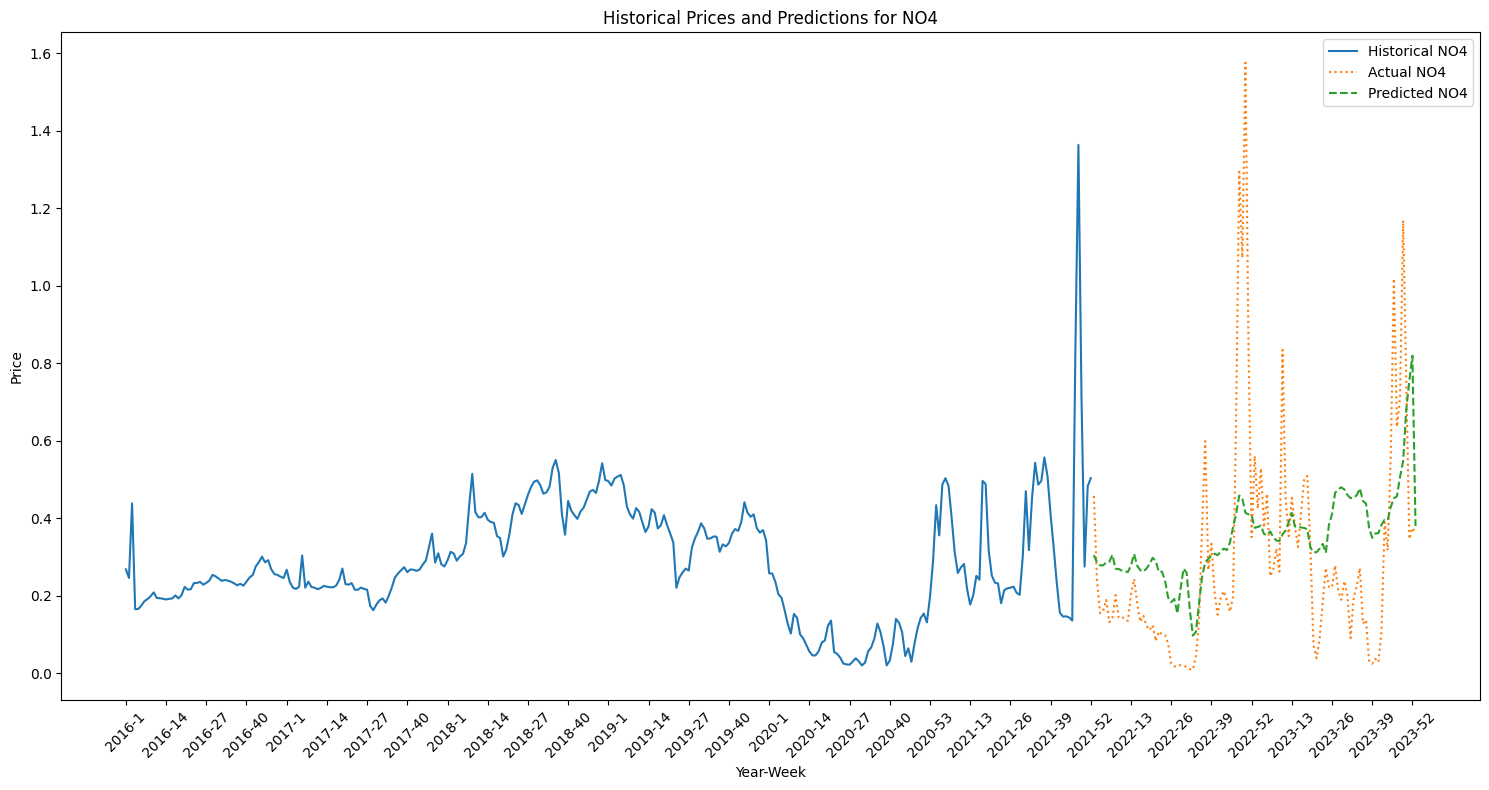

In [10]:
import matplotlib.pyplot as plt

def plot_price_predictions(historical_df, predictions_df, region=1):
    historical = historical_df[historical_df['region'] == region].toPandas()
    predictions = predictions_df[predictions_df['region'] == region].toPandas()
    
    # Sort by year and week
    historical = historical.sort_values(['year', 'week'])
    predictions = predictions.sort_values(['year', 'week'])
    
    # Create clean x-labels
    historical['time'] = historical.apply(lambda x: f"{x['year']:.0f}-{x['week']:.0f}", axis=1)
    predictions['time'] = predictions.apply(lambda x: f"{x['year']:.0f}-{x['week']:.0f}", axis=1)
    
    plt.figure(figsize=(15, 8))
    
    plt.plot(historical['time'], historical['price'], label=f'Historical NO{region}')
    plt.plot(predictions['time'], predictions['price'], linestyle=':', label=f'Actual NO{region}')
    plt.plot(predictions['time'], predictions['prediction'], linestyle='--', label=f'Predicted NO{region}')

    # Show every nth label to avoid crowding
    plt.xticks(range(0, len(historical['time']) + len(predictions['time']), 13), rotation=45)
    
    plt.xlabel('Year-Week')
    plt.ylabel('Price')
    plt.title(f'Historical Prices and Predictions for NO{region}')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_price_predictions(training_data, predictions, region=4)

### Reservoir level prediction

In [11]:
def create_reservoir_pipeline(training_data, test_data):
    feature_cols = [
        "week",
        "region",
        "price",
        "price_1w",
        "price_2w",
        "price_avg_4w"
    ]
    
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    
    rf = RandomForestRegressor(
        featuresCol="features",
        labelCol="reservoir_level",
        numTrees=100,
        maxDepth=8
    )
    
    pipeline = Pipeline(stages=[assembler, rf])
    
    model = pipeline.fit(training_data)
    predictions = model.transform(test_data)

    return model, predictions

model, predictions = create_reservoir_pipeline(training_data, test_data)
predictions.select("year", "week", "region", "reservoir_level", "prediction").show()

+----+----+------+-------------------+-------------------+
|year|week|region|    reservoir_level|         prediction|
+----+----+------+-------------------+-------------------+
|2022|   1|     1| 0.4778976839285714| 0.5493387647784257|
|2022|   1|     2| 0.4683651236904762| 0.6178372901548328|
|2022|   1|     3| 0.5849211190476191| 0.5636358447732518|
|2022|   1|     4| 0.6605296022619047| 0.4723140839644978|
|2022|   1|     5| 0.4595587754166666| 0.5837842781752125|
|2022|   2|     1|0.44489904880952386|  0.535612822404812|
|2022|   2|     2|0.45146500681547624| 0.5976478256617365|
|2022|   2|     3| 0.5887680116071425| 0.5790075086571363|
|2022|   2|     4| 0.6516015038690476|0.49646993448280574|
|2022|   2|     5|0.44055245991071407| 0.5713822279453653|
|2022|   3|     1|  0.414159849642857| 0.5018592524060572|
|2022|   3|     2| 0.4366778101785714| 0.5590748375018021|
|2022|   3|     3| 0.5754969595238095| 0.5557025968625859|
|2022|   3|     4| 0.6436083260416666|0.4785310479852576

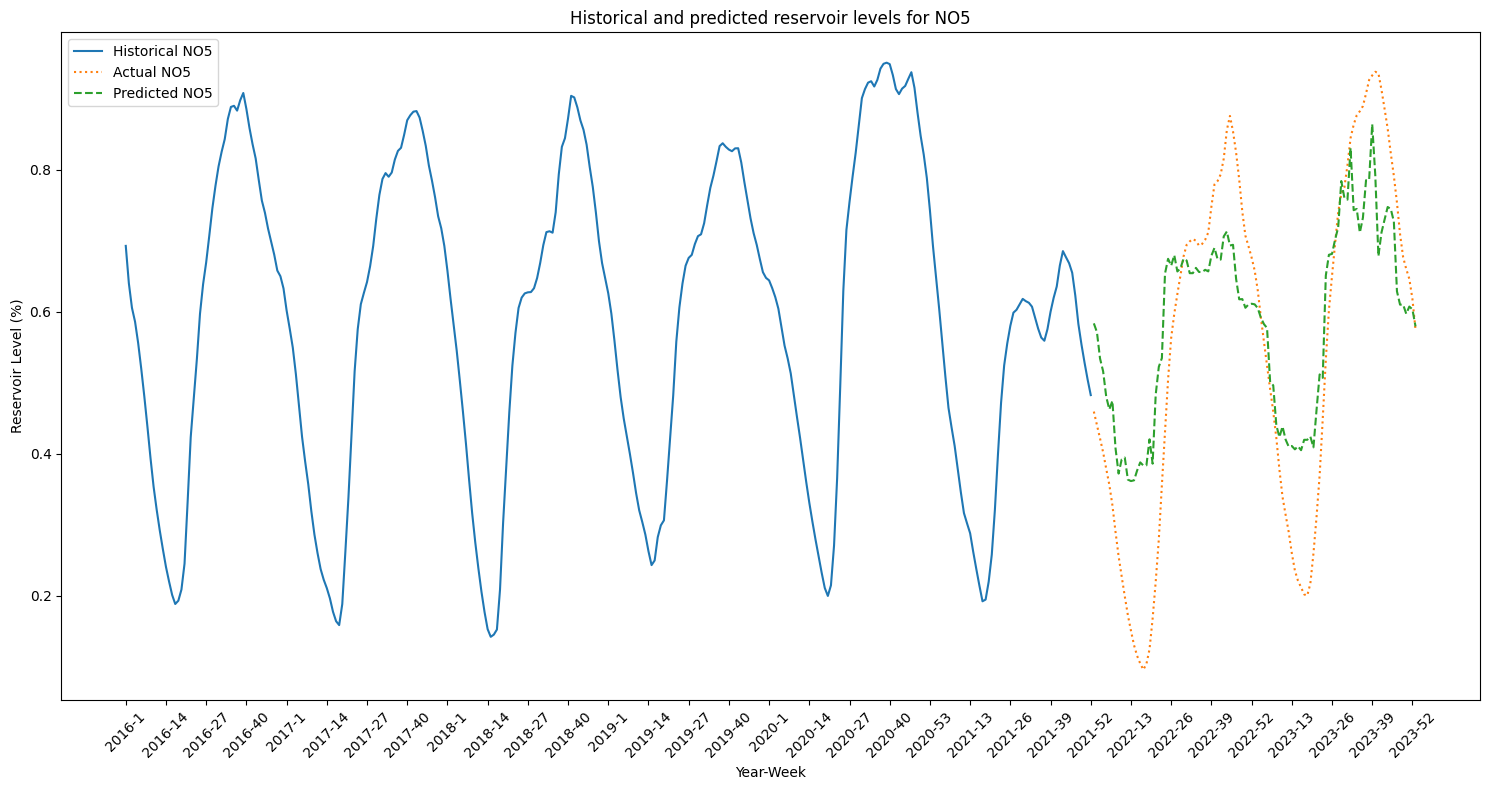

In [12]:
def plot_reservoir_predictions(historical_df, predictions_df, region=1):
    historical = historical_df[historical_df['region'] == region].toPandas()
    predictions = predictions_df[predictions_df['region'] == region].toPandas()
    
    plt.figure(figsize=(15, 8))
    
    historical['time'] = historical.apply(lambda x: f"{x['year']:.0f}-{x['week']:.0f}", axis=1)
    predictions['time'] = predictions.apply(lambda x: f"{x['year']:.0f}-{x['week']:.0f}", axis=1)
    
    # Show every nth label to avoid crowding
    plt.xticks(range(0, len(historical['time']) + len(predictions['time']), 13), rotation=45)
    
    plt.plot(historical['time'], historical['reservoir_level'], 
             label=f'Historical NO{region}')
    plt.plot(predictions['time'], predictions['reservoir_level'], 
             linestyle=':', label=f'Actual NO{region}')
    plt.plot(predictions['time'], predictions['prediction'], 
             linestyle='--', label=f'Predicted NO{region}')

    plt.xticks(rotation=45)
    plt.xlabel('Year-Week')
    plt.ylabel('Reservoir Level (%)')
    plt.title(f'Historical and predicted reservoir levels for NO{region}')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_reservoir_predictions(training_data, predictions, 5)

### Data set visualisation

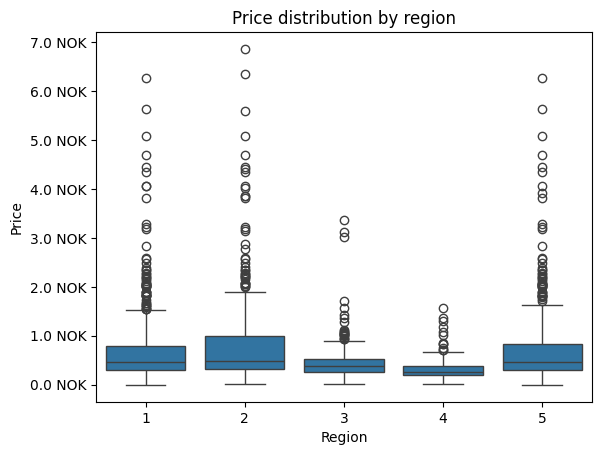

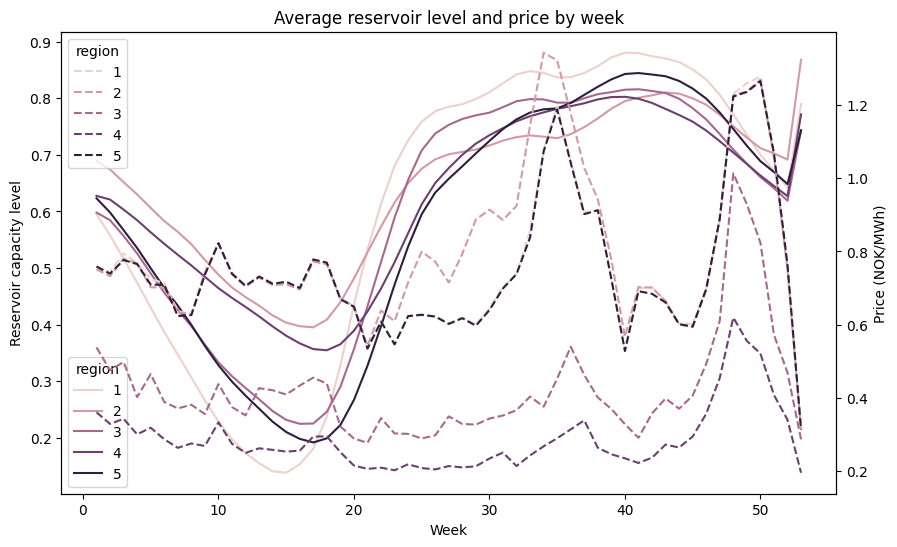

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker  
import pandas as pd

pdf = df.filter(F.col("year") >= 2016).toPandas()

plt.figure()
    
# Box plot: Price distribution by region
sns.boxplot(data=pdf, x='region', y='price')
plt.title('Price distribution by region')
plt.xlabel('Region')
plt.ylabel('Price')
    
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f NOK'))
plt.savefig("price_by_region.pdf")

# Line plot: Average reservoir level over weeks
plt.figure(figsize=(10, 6))
weekly_avg = pdf.groupby(['week', 'region'])[['reservoir_level', 'price']].mean().reset_index()

# Create twin axes
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot reservoir levels on left axis
sns.lineplot(data=weekly_avg, x='week', y='reservoir_level', hue='region', ax=ax1)
# Plot prices on right axis
sns.lineplot(data=weekly_avg, x='week', y='price', hue='region', ax=ax2, linestyle='--')

ax1.set_ylabel('Reservoir capacity level')
ax2.set_ylabel('Price (NOK/MWh)')
ax1.set_xlabel('Week')
plt.title('Average reservoir level and price by week')

plt.show()

In [14]:
#spark.stop()